In this notebook we will present 11 class - imbalance techniques. 
To test them we adopted 3 Machine- Learning models namely Multinomial Naive Bayes Classifier , Logistic Regression Classifier and  Random Forest Classifier.
We employed those algorithms into a SMS Spam Collection Dataset Kaggle Dataset with 5574 messages and a class ratio of spam/ham ~= 1/7.


Note 1 : The random forest classifier has max_depth = 20 (not optimal) in order to reduce the strength of the original imbalance unaware model to demonstrate the effectiveness of the class-imbalance techniques. 

For more details and explanations the authors created a corresponding report in which the key results are further exlained and analyzed. 

Happy Reading!  
Feel free to contact us for any useful observations-proposals! 

In [1]:
# importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import string
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from sklearn.metrics import balanced_accuracy_score

import math 

import sklearn.metrics as metrics

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss

from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import KMeansSMOTE
from imblearn.combine import SMOTETomek 
from imblearn.over_sampling import BorderlineSMOTE 
from imblearn.over_sampling import SMOTE

In [2]:
# timing of the code 

import time
start_time = time.time()

Dataset used 
https://www.kaggle.com/uciml/sms-spam-collection-dataset 

In [3]:
# Loading my data 

sms = pd.read_csv("spam_data.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms.describe() 

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
# we have an imbalace of spam/ham ~= 1/7 
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [6]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
#check message lenghts 
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

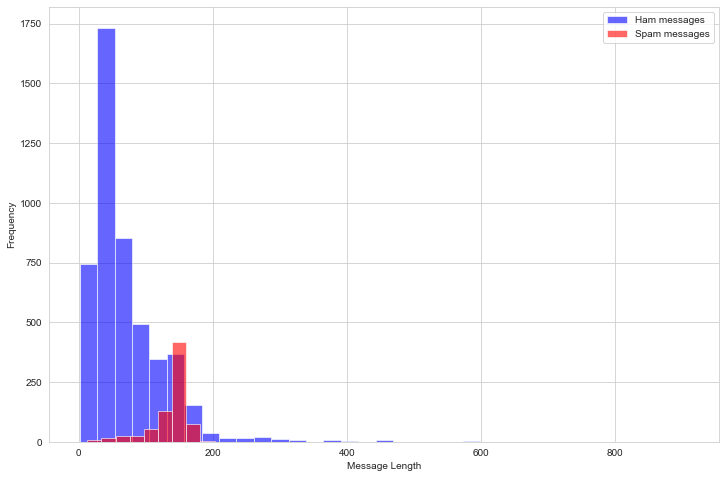

In [8]:
# visualize the imbalance in correlation with message lenght 
# it seems that spam messages tend to have more characters
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [9]:
#mean of ham messages = 71 
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [10]:
#mean of spam messages = 138 
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


In [11]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [12]:
# apply the tokenization
sms['clean_msg'] = sms.message.apply(text_process)

In [13]:
#check our dataset now
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [14]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [15]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [16]:
# vectorization 

# instantiate the vectorizer
# vect = CountVectorizer()
#tuned vectorizer 
vect = CountVectorizer(max_features=1500, max_df=0.85, stop_words=stopwords.words("english"))
#fit and transform 
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix
X_train_dtm

<4179x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 25645 stored elements in Compressed Sparse Row format>

In [17]:
# transform testing data into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 8088 stored elements in Compressed Sparse Row format>

In [18]:
#tf_idf
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 25645 stored elements in Compressed Sparse Row format>

Multinomial Naive Bayes Imbalance Unaware 

Wall time: 0 ns


Results for  imbalance unaware Multinomial Naive Bayes model


[[1199    7]
 [  18  169]]
Accuracy: 0.9820531227566404
Balanced accuracy : 0.9489695018667801
G-mean metric :0.9478911897157435
F1- score : 0.931129476584022


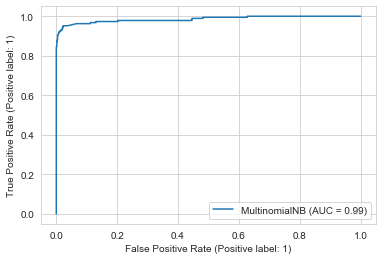

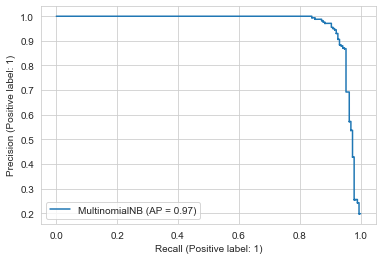

In [19]:
#Lets evaluate an imbalance aware Multinomial Naive Bayes model
nb = MultinomialNB()

# train
%time nb.fit(X_train_dtm, y_train)

#predictions
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for  imbalance unaware Multinomial Naive Bayes model')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Logistic Regression Imbalance Unaware 

Wall time: 30 ms


Results for  imbalance unaware Logistic Regression Model


[[1206    0]
 [  27  160]]
Accuracy: 0.9806173725771715
Balanced accuracy : 0.927807486631016
G-mean metric :0.9249945801257605
F1- score : 0.9221902017291067


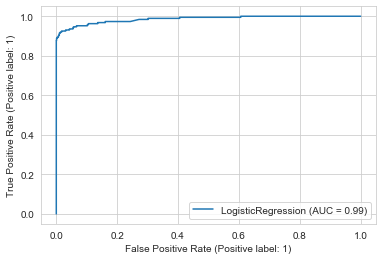

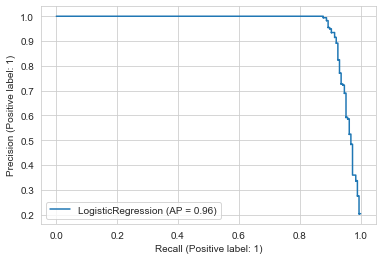

In [20]:
# now lets evaluate an imbalance unaware logistic regression model 

#model 
logreg = LogisticRegression(solver='lbfgs')
#fit 
%time logreg.fit(X_train_dtm, y_train)
#predictions
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for  imbalance unaware Logistic Regression Model')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Random Forest Imbalance Unaware 

Wall time: 216 ms


Results for  imbalance unaware Random Forest Model


[[1206    0]
 [  66  121]]
Accuracy: 0.9526202440775305
Balanced accuracy : 0.8235294117647058
G-mean metric :0.8043996665398437
F1- score : 0.7857142857142858
Recall : 0.6470588235294118
Precision : 1.0


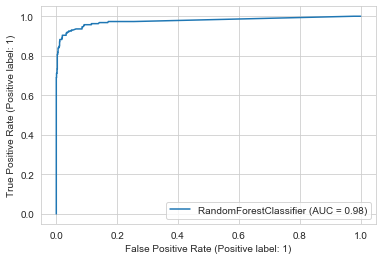

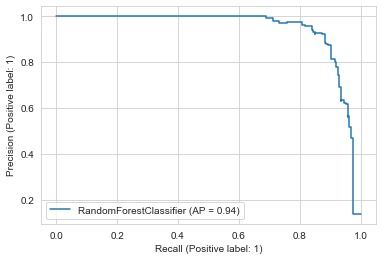

In [21]:
#model 
#max_depth parameter is relativly low in order to have a not so powerful baseline model 
#and to evaluate better the improvements of the imbalanced techniques 
rf = RandomForestClassifier(random_state = 42, max_depth = 20)
#fit 
%time rf.fit(X_train_dtm, y_train)
#predictions
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for  imbalance unaware Random Forest Model')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#RECALL 
print(f'Recall : {metrics.recall_score(y_test, y_pred_class)}')

#Precision 
print(f'Precision : {metrics.precision_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

Because of the exisitng class imbalance we will now try to implement some class imbalance techniques and evaluate them

Text(0.5, 1.0, 'Number of ham and spam messages')

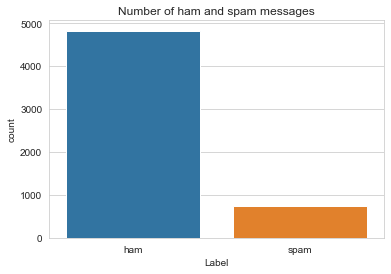

In [22]:
#Existing class imbalance 
# we have an imbalace of spam/ham ~= 1/7 
sns.countplot(sms.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

1) We will first try to Decrease the instances of the majority class -  Random undersampling technique

In [23]:
#undersmapling for naive bayes 
undersample_nb = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
#Final instances and their labels
under_X_nb, under_y_nb = undersample_nb.fit_resample(X_train_dtm, y_train) 
#prints the number of instances for each category on the train set 
print(Counter(under_y_nb))
#prints the number of instances for each category on the test set 
print(Counter(y_test))



print('\n')
# undersampling for logistic regression 
undersample_log = RandomUnderSampler(sampling_strategy = 0.77, random_state = 42)
#Final instances and their labels
under_X_log, under_y_log = undersample_log.fit_resample(X_train_dtm, y_train) 
#prints the number of instances for each category on the train set 
print(Counter(under_y_log))
#prints the number of instances for each category on the test set 
print(Counter(y_test))



print('\n')
# undersampling for random forest 
undersample_rf = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
#Final instances and their labels
under_X_rf, under_y_rf = undersample_rf.fit_resample(X_train_dtm, y_train) 
#prints the number of instances for each category on the train set 
print(Counter(under_y_rf))
#prints the number of instances for each category on the test set 
print(Counter(y_test))

Counter({0: 560, 1: 560})
Counter({0: 1206, 1: 187})


Counter({0: 727, 1: 560})
Counter({0: 1206, 1: 187})


Counter({0: 560, 1: 560})
Counter({0: 1206, 1: 187})


Naive Bayes Model 

Wall time: 0 ns


Results for  Random undersampling + Naive Bayes


[[1147   59]
 [   8  179]]
Accuracy: 0.9519023689877961
Balanced accuracy : 0.9541485974760777
G-mean metric :0.9541436564534888
F1- score : 0.8423529411764705


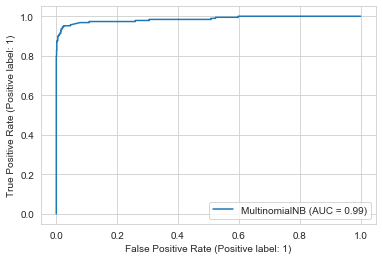

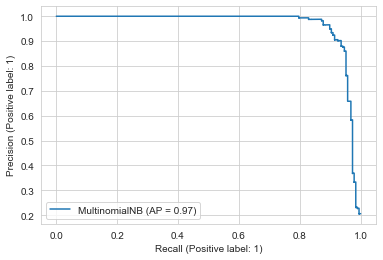

In [24]:
# train
%time nb.fit(under_X_nb, under_y_nb)

#predictions
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for  Random undersampling + Naive Bayes')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Logistic Regression Model 

Wall time: 21.8 ms


Results for  Random undersampling + Logistic Regression


[[1194   12]
 [  20  167]]
Accuracy: 0.9770279971284996
Balanced accuracy : 0.9415489397930136
G-mean metric :0.9402989297632774
F1- score : 0.912568306010929


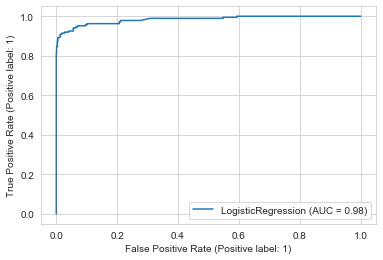

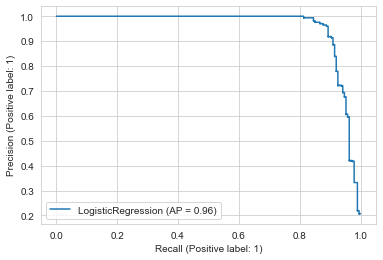

In [25]:
# train
%time logreg.fit(under_X_log, under_y_log)

#predictions
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for  Random undersampling + Logistic Regression')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Random Forest Model 

Wall time: 220 ms


Results for  Random undersampling + Random Forest


[[1187   19]
 [  26  161]]
Accuracy: 0.9676956209619526
Balanced accuracy : 0.9226040031571199
G-mean metric :0.9205424922136467
F1- score : 0.8773841961852862


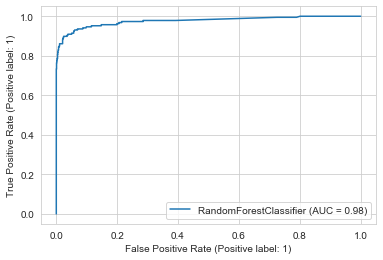

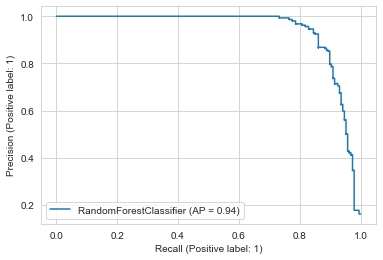

In [26]:
# train
%time rf.fit(under_X_rf, under_y_rf)

#predictions
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for  Random undersampling + Random Forest')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

2) Now we will try to evaluate imbalance aware models 

Logistic Regression imbalance aware model 

Wall time: 30.3 ms


Results for  imbalance aware Logistic Regression model


[[1199    7]
 [  19  168]]
Accuracy: 0.9813352476669059
Balanced accuracy : 0.9462957050753363
G-mean metric :0.9450826170543177
F1- score : 0.9281767955801105


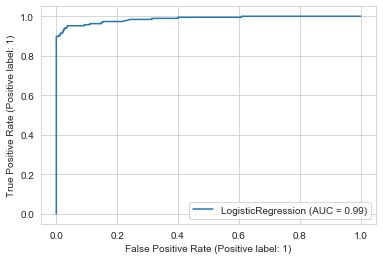

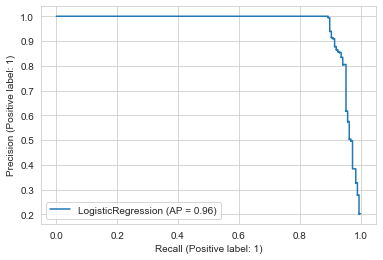

In [27]:
#model 
logreg_im_aware = LogisticRegression(solver='lbfgs', class_weight='balanced')
#fit 
%time logreg_im_aware.fit(X_train_dtm, y_train)
#predictions
y_pred_class = logreg_im_aware.predict(X_test_dtm)

print('\n')
print('Results for  imbalance aware Logistic Regression model')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg_im_aware, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg_im_aware, X_test_dtm, y_test)

Random Forest Imbalance Aware 

Wall time: 309 ms


Results for  imbalance unaware Random Forest Model


[[1197    9]
 [  28  159]]
Accuracy: 0.9734386216798278
Balanced accuracy : 0.9214023465559901
Recall : 0.8502673796791443
Precision : 0.9464285714285714
G-mean metric :0.9186523285369252
F1- score : 0.8957746478873239


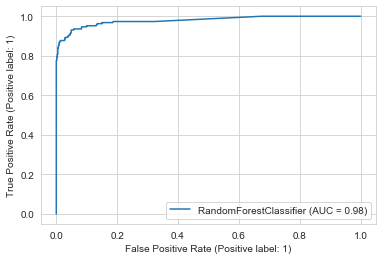

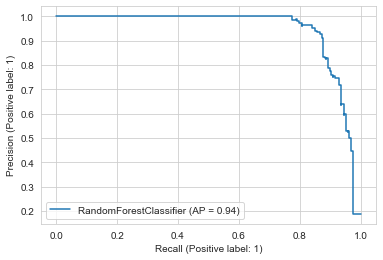

In [28]:
#model 
rf_ia = RandomForestClassifier(random_state = 42, class_weight='balanced', max_depth = 20)
#fit 
%time rf_ia.fit(X_train_dtm, y_train)
#predictions
y_pred_class = rf_ia.predict(X_test_dtm)

print('\n')
print('Results for  imbalance unaware Random Forest Model')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

#RECALL 
print(f'Recall : {metrics.recall_score(y_test, y_pred_class)}')

#Precision 
print(f'Precision : {metrics.precision_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf_ia, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf_ia, X_test_dtm, y_test)

MultinomialNB Imbalance Aware 

Wall time: 7.99 ms


Results for MultinomialNB Imbalance Aware 


[[1180   26]
 [  10  177]]
Accuracy: 0.9741564967695621
Balanced accuracy : 0.962482595932991
Recall : 0.946524064171123
Precision : 0.8719211822660099
G-mean metric :0.9623502858823884
F1- score : 0.9076923076923077


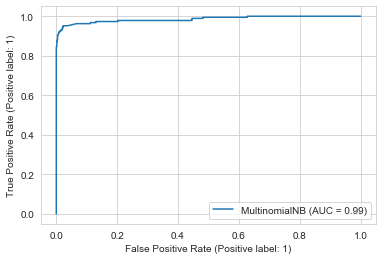

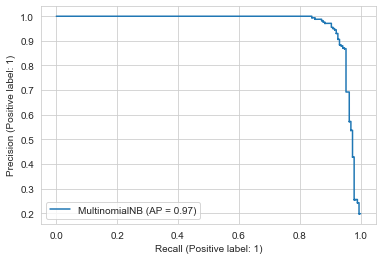

In [67]:
#model 
clf = MultinomialNB(class_prior = [2,1])
#fit 
%time clf.fit(X_train_dtm, y_train)
#predictions
y_pred_class = clf.predict(X_test_dtm)

print('\n')
print('Results for MultinomialNB Imbalance Aware ')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

#RECALL 
print(f'Recall : {metrics.recall_score(y_test, y_pred_class)}')

#Precision 
print(f'Precision : {metrics.precision_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(clf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(clf, X_test_dtm, y_test)

3) Easy Ensemble technique 

Wall time: 2.19 s


Results for Easy Ensemble Classifier


[[1181   25]
 [  21  166]]
Accuracy: 0.9669777458722182
Balanced accuracy : 0.9334854249252844
G-mean metric :0.9323619374365477
F1- score : 0.8783068783068783


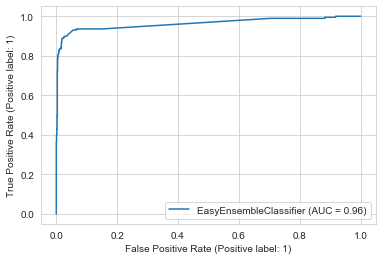

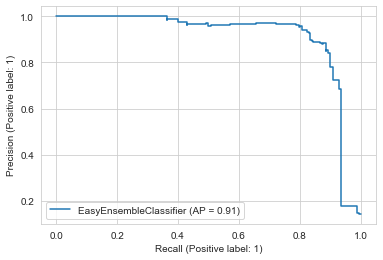

In [31]:
#model
eec = EasyEnsembleClassifier(random_state=42, n_jobs = -1, replacement = False, sampling_strategy = 0.46, n_estimators = 15)

#fit
%time eec.fit(X_train_dtm, y_train)
#predictions 
y_pred_class = eec.predict(X_test_dtm)

print('\n')
print('Results for Easy Ensemble Classifier')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(eec, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(eec, X_test_dtm, y_test)


4) Nearmiss (versions : 1,2,3)

NearMiss Version 1 + Naive Bayes 

Wall time: 45.7 ms
Counter({0: 2800, 1: 560})
Counter({0: 1206, 1: 187})
Wall time: 0 ns


Results for Nearmiss Version 1 + Naive Bayes


[[1194   12]
 [  15  172]]
Accuracy: 0.9806173725771715
Balanced accuracy : 0.9549179237502328
G-mean metric :0.9542714476481097
F1- score : 0.9272237196765498


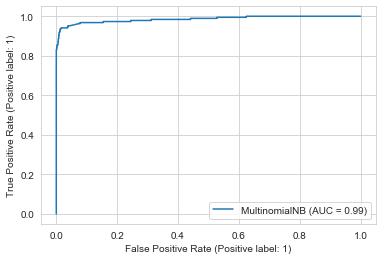

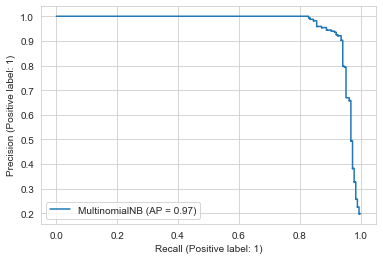

In [32]:
#mod 
nm1 = NearMiss(version=1, sampling_strategy = 0.2)
#resample
%time X_resampled_nm1, y_resampled = nm1.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(Counter(y_resampled))
#prints the number of instances for each category on the test set 
print(Counter(y_test))

#fit
%time nb.fit(X_resampled_nm1, y_resampled)

#predictions 
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 1 + Naive Bayes')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

NearMiss Version 1 + Logistic Regression

Wall time: 40 ms
 Train Set: Counter({0: 1120, 1: 560})
 Test Set: Counter({0: 1206, 1: 187})
Wall time: 8 ms


Results for Nearmiss Version 1 + Logistic Regression


[[1171   35]
 [  19  168]]
Accuracy: 0.9612347451543432
Balanced accuracy : 0.9346870815264143
G-mean metric :0.9339822683491675
F1- score : 0.8615384615384616


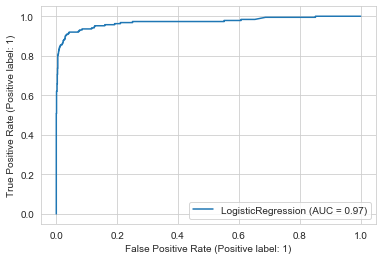

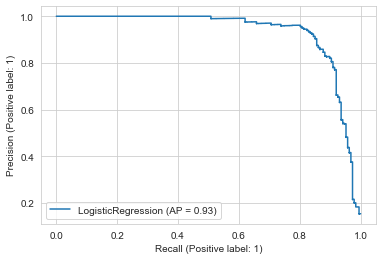

In [33]:
#mod 
nm1 = NearMiss(version=1, sampling_strategy = 0.5)
#resample
%time X_resampled_nm1, y_resampled = nm1.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(y_resampled)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

#fit
%time logreg.fit(X_resampled_nm1, y_resampled)

#predictions 
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 1 + Logistic Regression')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

NearMiss Version 1 + Random Forest

Wall time: 42.6 ms
Counter({0: 700, 1: 560})
Counter({0: 1206, 1: 187})
Wall time: 196 ms


Results for Nearmiss Version 1 + Random Forest


[[1180   26]
 [  24  163]]
Accuracy: 0.9641062455132807
Balanced accuracy : 0.9250494408527772
G-mean metric :0.9235073339168416
F1- score : 0.8670212765957447


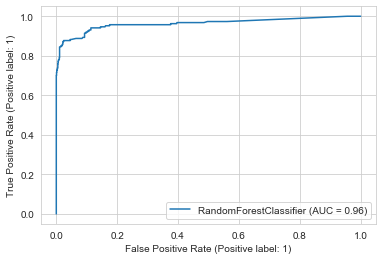

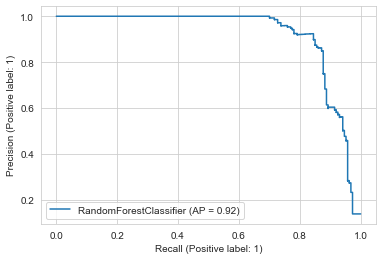

In [34]:
#mod 
nm1 = NearMiss(version=1, sampling_strategy = 0.8)
#resample
%time X_resampled_nm1, y_resampled = nm1.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(Counter(y_resampled))
#prints the number of instances for each category on the test set 
print(Counter(y_test))

#fit
%time rf.fit(X_resampled_nm1, y_resampled)

#predictions 
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 1 + Random Forest')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

NearMiss Version 2 + Naive Bayes 

Wall time: 126 ms
Counter({0: 2074, 1: 560})
Counter({0: 1206, 1: 187})
Wall time: 0 ns


Results for Nearmiss Version 2 + Naive Bayes


[[1192   14]
 [  12  175]]
Accuracy: 0.9813352476669059
Balanced accuracy : 0.9621101267282128
G-mean metric :0.9617511070261276
F1- score : 0.9308510638297873


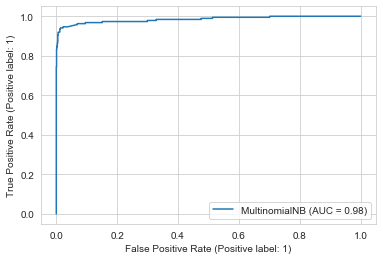

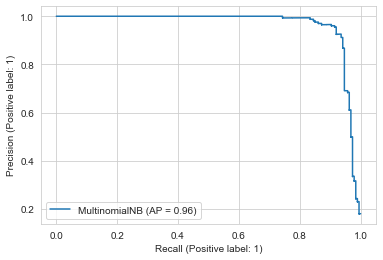

In [35]:
#mod 
nm2 = NearMiss(version=2, sampling_strategy = 0.27)
#resample
%time X_resampled_nm2, y_resampled = nm2.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(Counter(y_resampled))
#prints the number of instances for each category on the test set 
print(Counter(y_test))

#fit
%time nb.fit(X_resampled_nm2, y_resampled)

#predictions 
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 2 + Naive Bayes')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Nearmiss Version 2 + Logistic Regression

Wall time: 126 ms
 Train Set: Counter({0: 1120, 1: 560})
 Test Set: Counter({0: 1206, 1: 187})
Wall time: 15.6 ms


Results for Nearmiss Version 2 + Logistic Regression


[[1172   34]
 [  19  168]]
Accuracy: 0.9619526202440776
Balanced accuracy : 0.9351016752245901
G-mean metric :0.9343809801147565
F1- score : 0.8637532133676094


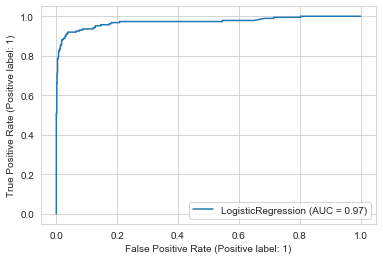

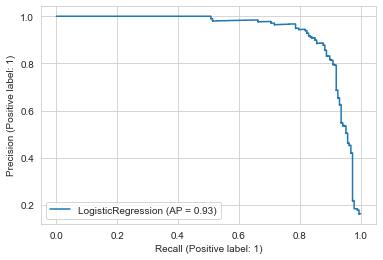

In [36]:
#mod 
nm2 = NearMiss(version=2, sampling_strategy = 0.5)
#resample
%time X_resampled_nm2, y_resampled = nm2.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(y_resampled)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

#fit
%time logreg.fit(X_resampled_nm2, y_resampled)

#predictions 
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 2 + Logistic Regression')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

NearMiss Version 2 + Random Forest 

Wall time: 109 ms
 Train Set: Counter({0: 746, 1: 560})
 Test Set: Counter({0: 1206, 1: 187})
Wall time: 200 ms


Results for Nearmiss Version 2 + Random Forest


[[1196   10]
 [  26  161]]
Accuracy: 0.9741564967695621
Balanced accuracy : 0.926335346440702
G-mean metric :0.9240257430144123
F1- score : 0.8994413407821229


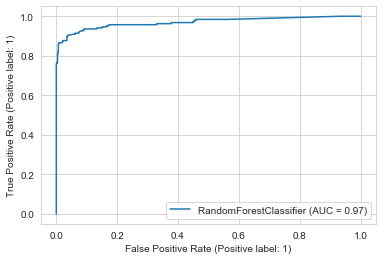

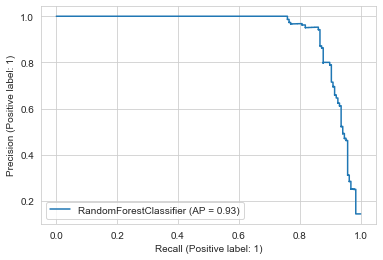

In [37]:
#mod 
nm2 = NearMiss(version=2, sampling_strategy = 0.75)
#resample
%time X_resampled_nm2, y_resampled = nm2.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(y_resampled)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

#fit
%time rf.fit(X_resampled_nm2, y_resampled)

#predictions 
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 2 + Random Forest')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

NearMiss Version 3 + Naive Bayes 

Wall time: 56.2 ms
Counter({1: 560, 0: 471})
Counter({0: 1206, 1: 187})
Wall time: 0 ns


Results for Nearmiss Version 3 + Naive Bayes


[[1119   87]
 [  12  175]]
Accuracy: 0.9289303661162958
Balanced accuracy : 0.9318447867613803
G-mean metric :0.931836269759495
F1- score : 0.779510022271715


C:\Users\nickg\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


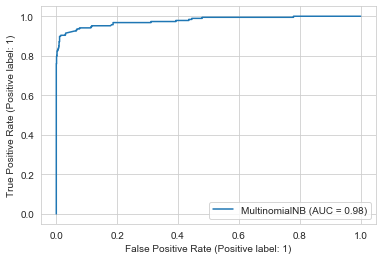

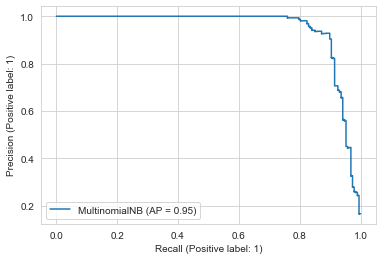

In [38]:
#mod 
nm3 = NearMiss(version=3, n_neighbors_ver3 = 7)
#resample
%time X_resampled_nm3, y_resampled = nm3.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(Counter(y_resampled))
#prints the number of instances for each category on the test set 
print(Counter(y_test))

#fit
%time nb.fit(X_resampled_nm3, y_resampled)

#predictions 
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 3 + Naive Bayes')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Nearmiss Version 3 + Logistic Regression

Wall time: 52.5 ms
 Train Set: Counter({1: 560, 0: 471})
 Test Set: Counter({0: 1206, 1: 187})
Wall time: 0 ns


Results for Nearmiss Version 3 + Logistic Regression


[[1163   43]
 [  16  171]]
Accuracy: 0.9576453697056713
Balanced accuracy : 0.9393917223153395
G-mean metric :0.939060245556216
F1- score : 0.8528678304239401


C:\Users\nickg\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


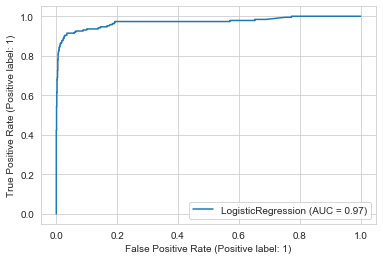

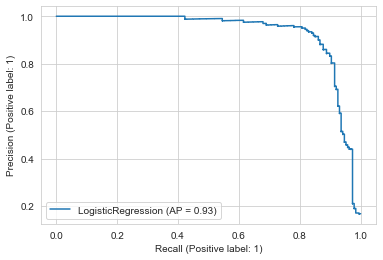

In [39]:
#mod 
nm3 = NearMiss(version=3, n_neighbors_ver3 = 7)
#resample
%time X_resampled_nm3, y_resampled = nm3.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(y_resampled)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

#fit
%time logreg.fit(X_resampled_nm3, y_resampled)

#predictions 
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 3 + Logistic Regression')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Nearmiss Version 3 + Random Forest 

C:\Users\nickg\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


Wall time: 55.5 ms
 Train Set: Counter({1: 560, 0: 407})
 Test Set: Counter({0: 1206, 1: 187})
Wall time: 163 ms


Results for Nearmiss Version 3 + Random Forest


[[1191   15]
 [  22  165]]
Accuracy: 0.9734386216798278
Balanced accuracy : 0.9349575651155985
G-mean metric :0.9334765139558207
F1- score : 0.8991825613079019


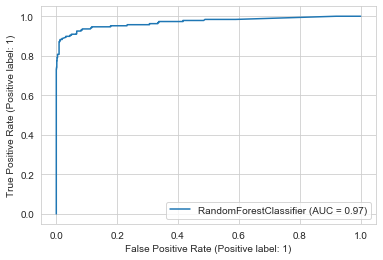

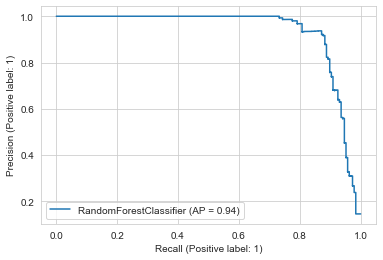

In [40]:
#mod 
nm3 = NearMiss(version=3, n_neighbors_ver3 = 5)
#resample
%time X_resampled_nm3, y_resampled = nm3.fit_resample(X_train_dtm, y_train)

#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(y_resampled)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

#fit
%time rf.fit(X_resampled_nm3, y_resampled)

#predictions 
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for Nearmiss Version 3 + Random Forest')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

5) Increase the instances of the minority class = Random Oversampling
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html 

In [41]:
#Oversampling for naive bayes 
oversample_nb = RandomOverSampler(sampling_strategy=0.57, random_state = 42)  
#Final instances and their labels
over_X_nb, over_y_nb = oversample_nb.fit_resample(X_train_dtm, y_train)   
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(over_y_nb)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')


print('\n')
#Oversampling for logistic regression 
oversample_log = RandomOverSampler(sampling_strategy=0.69, random_state = 42)  
#Final instances and their labels
over_X_log, over_y_log = oversample_log.fit_resample(X_train_dtm, y_train)   
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(over_y_log)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

print('\n')
#Oversampling for random forest 
oversample_rf = RandomOverSampler(sampling_strategy=1, random_state = 42)  
#Final instances and their labels
over_X_rf, over_y_rf = oversample_rf.fit_resample(X_train_dtm, y_train)   
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(over_y_rf)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')


 Train Set: Counter({0: 3619, 1: 2062})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 2497})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 3619})
 Test Set: Counter({0: 1206, 1: 187})


Naive Bayes + Random Oversampling

Wall time: 8 ms


Results for Naive Bayes + Random Oversampling


[[1182   24]
 [  13  174]]
Accuracy: 0.9734386216798278
Balanced accuracy : 0.9552903929550111
G-mean metric :0.9549681894997034
F1- score : 0.903896103896104


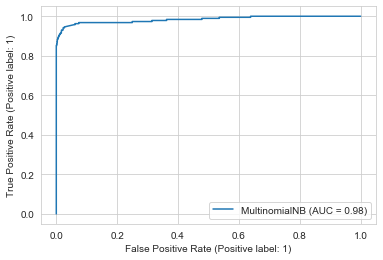

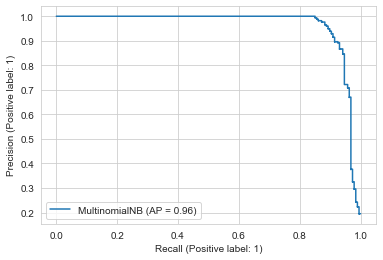

In [42]:
# Now its time to evaluate some models 

#Lets evaluate an imbalance aware Multinomial Naive Bayes model
nb = MultinomialNB()

# train
%time nb.fit(over_X_nb, over_y_nb)

#predictions
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Naive Bayes + Random Oversampling')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Logistic + Random Oversampling

Wall time: 37.1 ms


Results for  Random Oversampling + Logistic Regression


[[1201    5]
 [  19  168]]
Accuracy: 0.9827709978463748
Balanced accuracy : 0.947124892471688
G-mean metric :0.945870514329182
F1- score : 0.9333333333333333


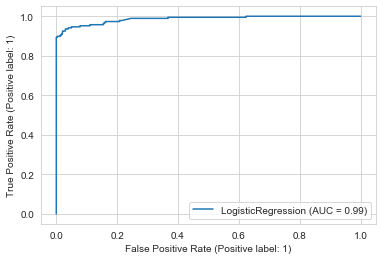

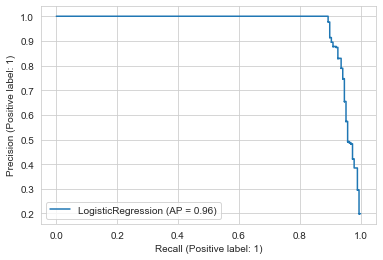

In [43]:
# train
%time logreg.fit(over_X_log, over_y_log)

#predictions
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for  Random Oversampling + Logistic Regression')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Random Oversampling + Random Forest 

Wall time: 269 ms


Results for  Random Oversampling + Random Forest


[[1196   10]
 [  26  161]]
Accuracy: 0.9741564967695621
Balanced accuracy : 0.926335346440702
G-mean metric :0.9240257430144123
F1- score : 0.8994413407821229


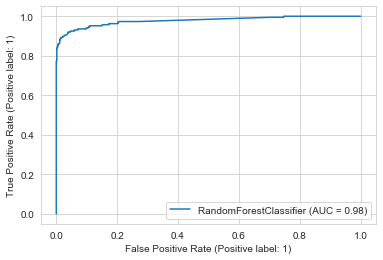

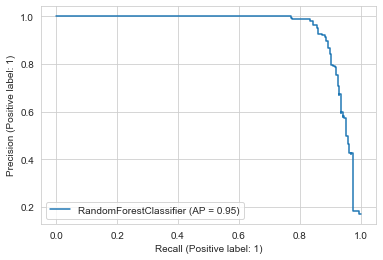

In [44]:
# train
%time rf.fit(over_X_rf, over_y_rf)

#predictions
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for  Random Oversampling + Random Forest')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

6) Oversample with SMOTE 

In [45]:
#smote for nb 
sm_nb = SMOTE(random_state=42, sampling_strategy = 0.24)
#Final instances and their labels
smote_X_nb, smote_y_nb = sm_nb.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(smote_y_nb)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')


print('\n')
#smote for logistic regression  
sm_log = SMOTE(random_state=42, sampling_strategy = 0.55)
#Final instances and their labels
smote_X_log, smote_y_log = sm_log.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(smote_y_log)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')


print('\n')
#smote for random forest 
sm_rf = SMOTE(random_state=42, sampling_strategy = 0.75)
#Final instances and their labels
smote_X_rf, smote_y_rf = sm_rf.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(smote_y_rf)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

 Train Set: Counter({0: 3619, 1: 868})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 1990})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 2714})
 Test Set: Counter({0: 1206, 1: 187})


Naive Bayes + SMOTE 

Wall time: 8 ms


Results for Naive Bayes +SMOTE


[[1193   13]
 [  16  171]]
Accuracy: 0.9791816223977028
Balanced accuracy : 0.9518295332606131
G-mean metric :0.9510948276690251
F1- score : 0.921832884097035


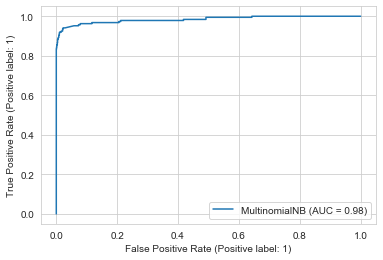

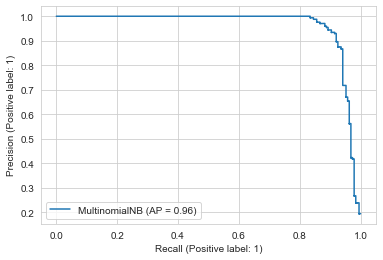

In [46]:
# train
%time nb.fit(smote_X_nb, smote_y_nb)

#predictions
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Naive Bayes +SMOTE')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Logistic + SMOTE 

Wall time: 53.3 ms


Results for SMOTE + Logistic Regression


[[1183   23]
 [  16  171]]
Accuracy: 0.9720028715003589
Balanced accuracy : 0.9476835962788552
G-mean metric :0.9471002916308364
F1- score : 0.8976377952755905


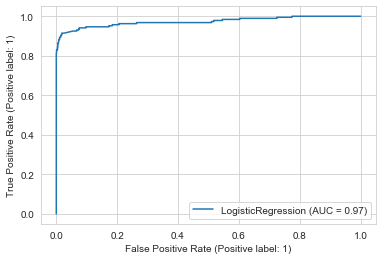

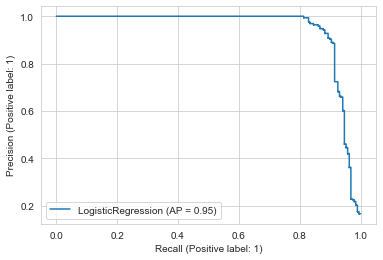

In [47]:
# train
%time logreg.fit(smote_X_log, smote_y_log)

#predictions
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for SMOTE + Logistic Regression')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Random Forest + SMOTE 

Wall time: 236 ms


Results for Random Forest +SMOTE


[[1193   13]
 [  27  160]]
Accuracy: 0.9712849964106246
Balanced accuracy : 0.9224177685547308
G-mean metric :0.9199956121018027
F1- score : 0.888888888888889


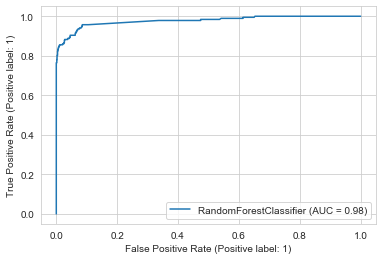

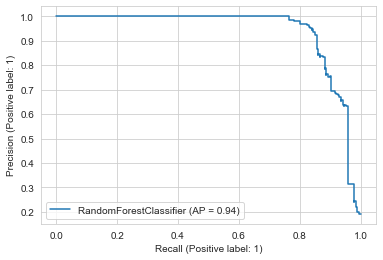

In [48]:
# train
%time rf.fit(smote_X_rf, smote_y_rf)

#predictions
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for Random Forest +SMOTE')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

7) Apply a KMeans clustering before to over-sample using SMOTE.
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html#imblearn.over_sampling.KMeansSMOTE 

In [49]:
#naive bayes 
kmeans_sm_nb = KMeansSMOTE(random_state=42, sampling_strategy = 0.2) 
#Final instances and their labels
kmeans_smote_X_nb, kmeans_smote_y_nb = kmeans_sm_nb.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(kmeans_smote_y_nb)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

print('\n')
#logistic regression 
kmeans_sm_log = KMeansSMOTE(random_state=42, sampling_strategy = 0.35) 
#Final instances and their labels
kmeans_smote_X_log, kmeans_smote_y_log = kmeans_sm_log.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(kmeans_smote_y_log)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')
print('\n')

#Random Forest 
kmeans_sm_rf = KMeansSMOTE(random_state=42, sampling_strategy = 1) 
#Final instances and their labels
kmeans_smote_X_rf, kmeans_smote_y_rf = kmeans_sm_rf.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(kmeans_smote_y_rf)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')


 Train Set: Counter({0: 3619, 1: 723})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 1266})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 3619})
 Test Set: Counter({0: 1206, 1: 187})


Naive bayes + KMeansSMOTE

Wall time: 11.9 ms


Results for Naive bayes + KMeansSMOTE


[[1196   10]
 [  14  173]]
Accuracy: 0.9827709978463748
Balanced accuracy : 0.9584209079380283
G-mean metric :0.9578426790888054
F1- score : 0.9351351351351352


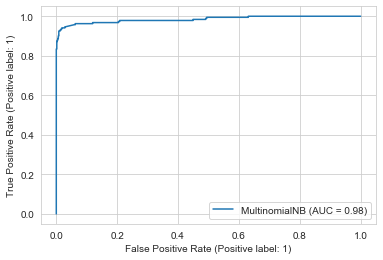

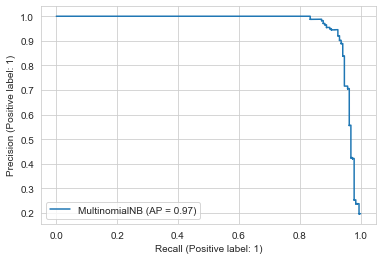

In [50]:
# train
%time nb.fit(kmeans_smote_X_nb, kmeans_smote_y_nb)

#predictions
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Naive bayes + KMeansSMOTE')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Logistic + KMeansSMOTE

Wall time: 44.9 ms


Results for Logistic + KMeansSMOTE


[[1201    5]
 [  24  163]]
Accuracy: 0.9791816223977028
Balanced accuracy : 0.9337559085144687
G-mean metric :0.931688744105512
F1- score : 0.9183098591549297


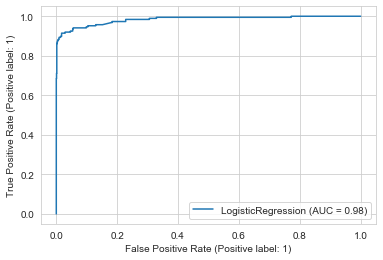

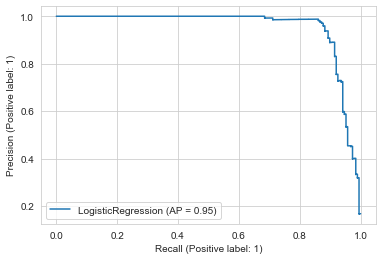

In [51]:
# train
%time logreg.fit(kmeans_smote_X_log, kmeans_smote_y_log)

#predictions
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for Logistic + KMeansSMOTE')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Random Forest + Kmeans Smote 

Wall time: 277 ms


Results for Random Forest + KMeansSMOTE


[[1198    8]
 [  40  147]]
Accuracy: 0.9655419956927495
Balanced accuracy : 0.8897313787568397
G-mean metric :0.8836751030880052
F1- score : 0.8596491228070176


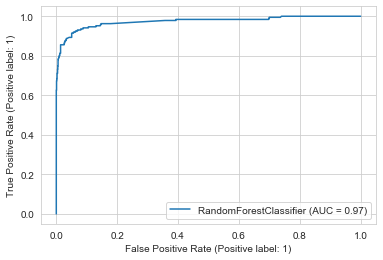

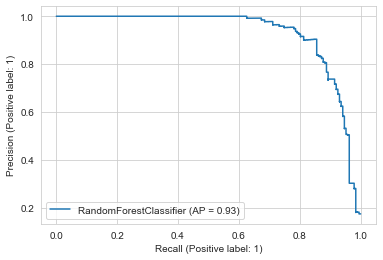

In [52]:
# train
%time rf.fit(kmeans_smote_X_rf, kmeans_smote_y_rf)

#predictions
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for Random Forest + KMeansSMOTE')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

8)Over-sampling using Borderline SMOTE.
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html 

In [53]:
#naive bayes 
bord_sm_nb = BorderlineSMOTE(random_state=42, sampling_strategy=0.38) 
#Final instances and their labels
bord_smote_X_nb, bord_smote_y_nb = bord_sm_nb.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(bord_smote_y_nb)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

print('\n')
#logistic regression 
bord_sm_log = BorderlineSMOTE(random_state=42,  sampling_strategy=0.56 ) 
#Final instances and their labels
bord_smote_X_log, bord_smote_y_log = bord_sm_log.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(bord_smote_y_log)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

print('\n')
#random forest 
bord_sm_rf = BorderlineSMOTE(random_state=42,  sampling_strategy=0.75) 
#Final instances and their labels
bord_smote_X_rf, bord_smote_y_rf = bord_sm_rf.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(bord_smote_y_rf)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

 Train Set: Counter({0: 3619, 1: 1375})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 2026})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 2714})
 Test Set: Counter({0: 1206, 1: 187})


Naive bayes + Borderline smote 

Wall time: 10.9 ms


Results for Naive bayes + Borderline smote 


[[1186   20]
 [  14  173]]
Accuracy: 0.9755922469490309
Balanced accuracy : 0.9542749709562703
G-mean metric :0.9538299145699238
F1- score : 0.9105263157894736


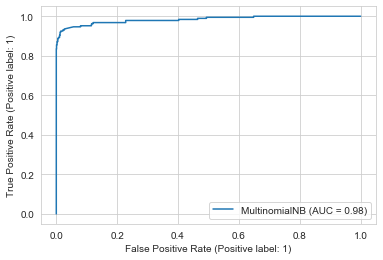

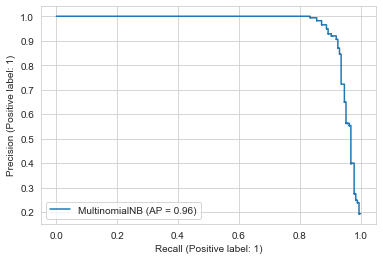

In [54]:
# train
%time nb.fit(bord_smote_X_nb, bord_smote_y_nb)

#predictions
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Naive bayes + Borderline smote ')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Logistic regression + Borderline smote 

Wall time: 44.5 ms


Results for Logistic regression + Borderline smote


[[1184   22]
 [  16  171]]
Accuracy: 0.9727207465900933
Balanced accuracy : 0.9480981899770311
G-mean metric :0.9475005030544158
F1- score : 0.8999999999999999


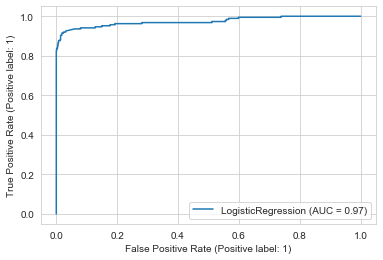

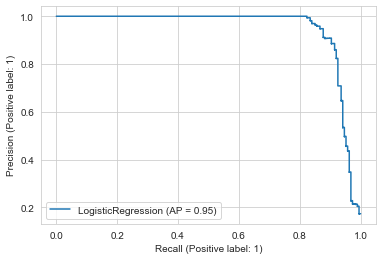

In [55]:
# train
%time logreg.fit(bord_smote_X_log, bord_smote_y_log)

#predictions
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for Logistic regression + Borderline smote')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Random Forest + Borderline Smote 

Wall time: 243 ms


Results for Random Forest + Borderline smote


[[1195   11]
 [  27  160]]
Accuracy: 0.9727207465900933
Balanced accuracy : 0.9232469559510823
G-mean metric :0.9207664506217024
F1- score : 0.893854748603352


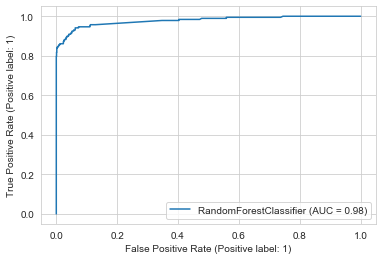

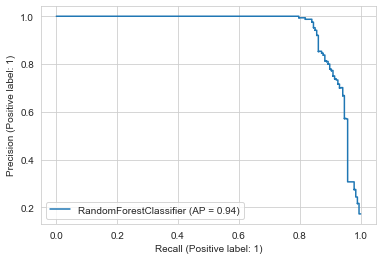

In [56]:
# train
%time rf.fit(bord_smote_X_rf, bord_smote_y_rf)

#predictions
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for Random Forest + Borderline smote')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

9)Combine over- and under-sampling using SMOTE and Tomek links.
https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html 

In [57]:
#naive bayes 
tomek_sm_nb = SMOTETomek(random_state=42, sampling_strategy = 0.2) 
#Final instances and their labels
tomek_smote_X_nb, tomek_smote_y_nb = tomek_sm_nb.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(tomek_smote_y_nb)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

print('\n')
#logistic regression 
tomek_sm_log = SMOTETomek(random_state=42, sampling_strategy = 0.55) 
#Final instances and their labels
tomek_smote_X_log, tomek_smote_y_log = tomek_sm_log.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(tomek_smote_y_log)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

print('\n')
#random forest 
tomek_sm_rf = SMOTETomek(random_state=42, sampling_strategy = 0.75) 
#Final instances and their labels
tomek_smote_X_rf, tomek_smote_y_rf = tomek_sm_rf.fit_resample(X_train_dtm, y_train)
#prints the number of instances for each category on the train set 
print(f' Train Set: {Counter(tomek_smote_y_rf)}')
#prints the number of instances for each category on the test set 
print(f' Test Set: {Counter(y_test)}')

 Train Set: Counter({0: 3619, 1: 723})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3617, 1: 1988})
 Test Set: Counter({0: 1206, 1: 187})


 Train Set: Counter({0: 3619, 1: 2714})
 Test Set: Counter({0: 1206, 1: 187})


Naive bayes + tomek_Smote 

Wall time: 10.7 ms


Results for Naive bayes + tomek_Smote  


[[1196   10]
 [  17  170]]
Accuracy: 0.9806173725771715
Balanced accuracy : 0.9503995175636967
G-mean metric :0.9495013648496506
F1- score : 0.9264305177111717


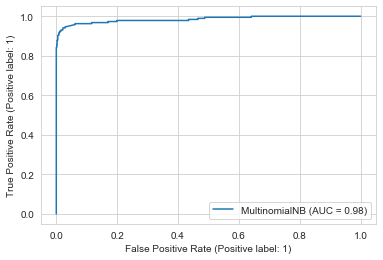

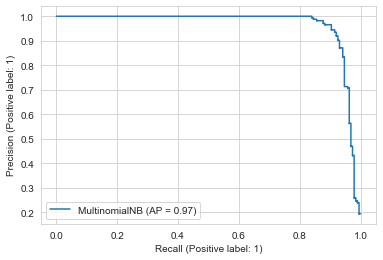

In [58]:
# train
%time nb.fit(tomek_smote_X_nb, tomek_smote_y_nb)

#predictions
y_pred_class = nb.predict(X_test_dtm)

print('\n')
print('Results for Naive bayes + tomek_Smote  ')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(nb, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(nb, X_test_dtm, y_test)

Logistic Regression + tomek_Smote 

Wall time: 44.8 ms


Results for Logistic Regression + tomek_Smote 


[[1183   23]
 [  16  171]]
Accuracy: 0.9720028715003589
Balanced accuracy : 0.9476835962788552
G-mean metric :0.9471002916308364
F1- score : 0.8976377952755905


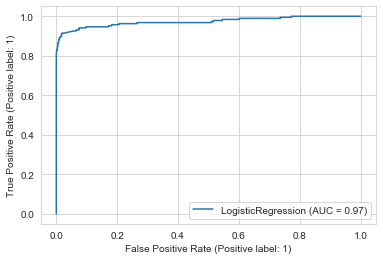

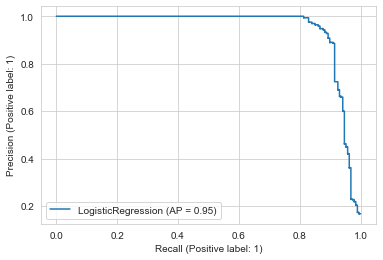

In [59]:
# train
%time logreg.fit(tomek_smote_X_log, tomek_smote_y_log)

#predictions
y_pred_class = logreg.predict(X_test_dtm)

print('\n')
print('Results for Logistic Regression + tomek_Smote ')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(logreg, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(logreg, X_test_dtm, y_test)

Random Forest + Tomek Smote 

Wall time: 243 ms


Results for Random Forest + tomek_Smote 


[[1193   13]
 [  27  160]]
Accuracy: 0.9712849964106246
Balanced accuracy : 0.9224177685547308
G-mean metric :0.9199956121018027
F1- score : 0.888888888888889


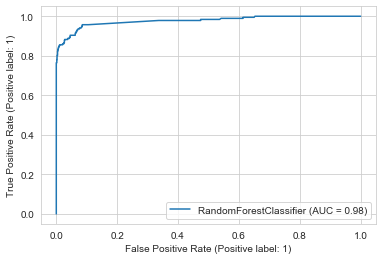

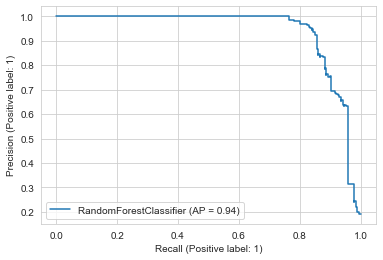

In [60]:
# train
%time rf.fit(tomek_smote_X_rf, tomek_smote_y_rf)

#predictions
y_pred_class = rf.predict(X_test_dtm)

print('\n')
print('Results for Random Forest + tomek_Smote ')
print('\n')

#confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(cm)

#accuracy score 
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

#balanced accuracy metric 
print(f'Balanced accuracy : {balanced_accuracy_score(y_test, y_pred_class)}')

# G-mean metric 
print(f'G-mean metric :{math.sqrt((tp/(tp+fn))*(tn/(tn+fp)))}')

#f1 score 
print(f'F1- score : {f1_score(y_test, y_pred_class)}')

#ROC curve and AUC 
metrics.plot_roc_curve(rf, X_test_dtm, y_test) 

#PRESICION RECALL CURVE 
metrics.plot_precision_recall_curve(rf, X_test_dtm, y_test)

In [61]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 85.03275799751282 seconds ---
